# Análisis de Series de Tiempo II

### Imputación de datos faltantes y suavizado de la serie

---

Imputa las temperaturas faltantes por diferentes métodos:
- simple (lineal)
- por tiempo (método `time` de Pandas)
- polinómica de grado 2
- Modelo LSTM bidireccional

Suaviza la serie con un filtro de Kalman.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [3]:
# después de imputar, completo las otras columnas, que dependen de las primeras.
# clip de outliers (opcional)
def set_mes_delta(df, clip=True):

    df['mes'] = df['fecha'].dt.month
    df['delta'] = df['estepa']- df['pino']

    if clip:
        q1 = df['delta'].quantile(.25)
        q3 = df['delta'].quantile(.75)
        pmin_delta = q1 - (q3-q1)*1.5
        pmax_delta = q3 + (q3-q1)*1.5
        df['delta'] = df['delta'].clip(lower=pmin_delta, upper=pmax_delta)


In [4]:
# plot de delta con línea de valores extremos
def plot_delta(df, titulo=''):
    fig, axs = plt.subplots(1, 1, figsize=(14, 4))

    q1 = df['delta'].quantile(.25)
    q3 = df['delta'].quantile(.75)
    pmin_delta = q1 - (q3-q1)*1.5
    pmax_delta = q3 + (q3-q1)*1.5
            
    plt.bar(df['fecha'], df['delta'])
    # Línea horizontal en los percentiles extremos
    plt.axhline(y=pmin_delta, linestyle='--', linewidth=1, color='blue', label=f'{pmin_delta:.2f}')
    plt.axhline(y=pmax_delta, linestyle='--', linewidth=1, color='red', label=f'{pmax_delta:.2f}')
    plt.title(titulo)
    plt.grid(axis='y')
    plt.legend()
    plt.show()  


### Lee las temperaturas diurnas x día

In [5]:
# Temperaturas diurnas (diarias)
df_dia = pd.read_csv("csv/ts_d_diario.csv", parse_dates=["fecha"],
    dtype={"pino": "float64",
           "estepa": "float64",
           "mes": "int64",
           "delta": "float64"
          })
df_dia.head(10)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,NaN,17.944593,1,NaN
5,2020-01-06,NaN,NaN,1,NaN
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,NaN,NaN,1,NaN
8,2020-01-09,NaN,NaN,1,NaN
9,2020-01-10,27.450967,22.472114,1,4.978853


In [6]:
# Estadísticas
df_dia[['estepa', 'pino', 'delta']].describe()

,estepa,pino,delta
count,1550.000000,1537.000000,1517.000000
mean,20.308426,17.074604,3.345054
std,13.046044,11.390663,2.356220
min,-13.921825,-10.614593,-8.212904
25%,8.566924,6.769585,1.609815
50%,21.533744,17.630912,3.358275
75%,31.620656,26.673017,4.998284
max,47.598174,42.566516,10.811992


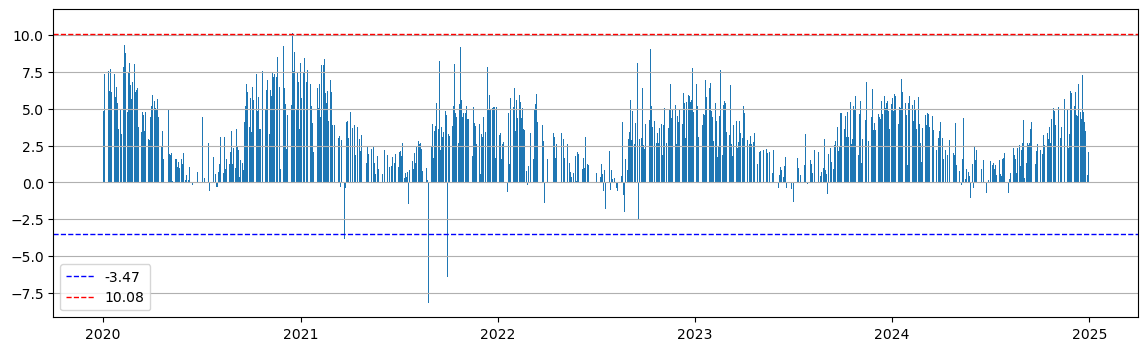

In [7]:
plot_delta(df_dia)

## Imputación simple

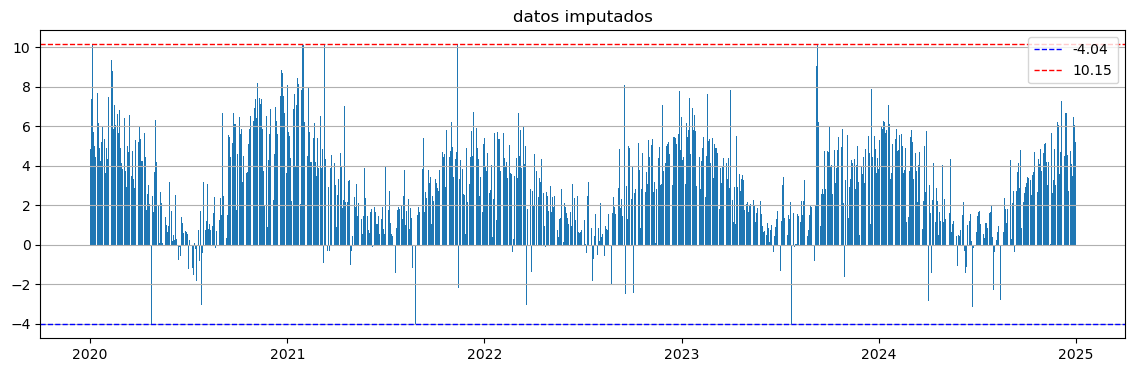

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,34.411211,17.944593,1,10.151255
5,2020-01-06,30.001096,18.733816,1,10.151255
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,26.210976,20.506064,1,5.704912
8,2020-01-09,26.830971,21.489089,1,5.341882
9,2020-01-10,27.450967,22.472114,1,4.978853


In [8]:
df_imputed = df_dia.copy()

df_imputed= df_imputed.set_index('fecha')
df_imputed['estepa'] = df_imputed['estepa'].interpolate(method='linear')
df_imputed['pino']   = df_imputed['pino'].interpolate(method='linear')
df_imputed = df_imputed.reset_index()

set_mes_delta(df_imputed, clip=True)

plot_delta(df_imputed, 'datos imputados')

df_imputed.head(15)

In [9]:
# Exporta el resultado
salida = 'csv/ts_imputado_simple.csv'
df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)

## Imputación por interpolación. Método `time`

In [10]:
df_imputed = df_dia.copy()

df_imputed= df_imputed.set_index('fecha')
df_imputed['estepa'] = df_imputed['estepa'].interpolate(method='time')
df_imputed['pino']   = df_imputed['pino'].interpolate(method='time')
df_imputed = df_imputed.reset_index()

set_mes_delta(df_imputed)
df_imputed.head(15)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,34.411211,17.944593,1,10.151255
5,2020-01-06,30.001096,18.733816,1,10.151255
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,26.210976,20.506064,1,5.704912
8,2020-01-09,26.830971,21.489089,1,5.341882
9,2020-01-10,27.450967,22.472114,1,4.978853


In [11]:
# Exporta el resultado
salida = 'csv/ts_imputado_time.csv'
df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)

## Imputación por interpolación. Método polinómico

In [12]:
df_imputed = df_dia.copy()

df_imputed= df_imputed.set_index('fecha')
df_imputed['estepa'] = df_imputed['estepa'].interpolate(method='polynomial', order=2)
df_imputed['pino']   = df_imputed['pino'].interpolate(method='polynomial', order=2)
df_imputed = df_imputed.reset_index()

set_mes_delta(df_imputed)
df_imputed.head(15)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,37.634369,17.944593,1,10.157978
5,2020-01-06,31.017693,15.534118,1,10.157978
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,22.457512,20.567543,1,1.889969
8,2020-01-09,22.104028,19.628610,1,2.475419
9,2020-01-10,27.450967,22.472114,1,4.978853


In [13]:
# Exporta el resultado
salida = 'csv/ts_imputado_polinomio.csv'
df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)

## Imputación con BiLSTM

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-12-12 10:54:30.735205: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
df = df_dia.copy()

In [16]:
cols_to_impute = ['estepa', 'pino']
data = df[cols_to_impute].copy()

data.head(15)

,estepa,pino
0,35.433453,33.666374
1,36.195872,31.342840
2,35.245773,31.284172
3,38.821326,31.450303
4,NaN,17.944593
5,NaN,NaN
6,25.590980,19.523039
7,NaN,NaN
8,NaN,NaN
9,27.450967,22.472114


In [17]:
# Parámetros
TEST_SIZE_FOR_MASK = 0.15        # 15 % de valores CONOCIDOS los borramos artificialmente para validar
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [18]:
# Máscara de valores REALMENTE faltantes + máscara de validación artificial

real_missing = data.isna().values                     # True donde faltan de verdad
known_values = ~real_missing                          # True donde SÍ tenemos valor real

# Borramos artificialmente un % de los valores que sí conocemos (para validar)
mask_val = np.random.random(data.shape) < TEST_SIZE_FOR_MASK
mask_val = mask_val & known_values                    # solo borramos donde había valor real

validation_missing = mask_val.copy()                  # estos los usamos para medir error realista
train_missing = real_missing | validation_missing     # valtantes verdaderos y artificiales

# Serie que el modelo verá (con todos los gaps: verdaderos y artificiales)
data_train = data.copy()
data_train.values[train_missing] = np.nan

In [19]:
# Relleno provisorio para poder entrenar (solo interpolación simple)
data_filled = data_train.interpolate(method='linear', limit_direction='both')
data_filled = data_filled.fillna(method='bfill').fillna(method='ffill')

In [20]:
# Normalización
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data_filled),
    index=data_filled.index,
    columns=data_filled.columns
)

In [21]:
# Preparamos tensores (una sola secuencia grande)
X_train = data_scaled.values.reshape(1, -1, 2)      # shape (1, n_timesteps, 2)
X_with_real_gaps = np.where(train_missing, 0, data_scaled.values)
X_with_real_gaps = X_with_real_gaps.reshape(1, -1, 2)
y_train = X_train[:, :, :2]    # dos variables: estepa y pino

### Modelo BiLSTM 1

Esta arquitectura fue la primera prueba. Era demasiado grande y performó mal.

In [22]:
# Modelo BiLSTM multivariado

model = Sequential([
    Input(shape=(None, 2)),
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, recurrent_dropout=0.2)),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True, recurrent_dropout=0.2)),
    Bidirectional(LSTM(32, activation='tanh', return_sequences=True, recurrent_dropout=0.1)),
    TimeDistributed(Dense(2))
])

# model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, None, 256)      │       134,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 128)      │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 64)       │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 2)        │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,842 (1.30 MB)

 Trainable params: 339,842 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo BiLSTM 2

3 capas BiLSTM pueden ser demasiado profundas para este dataset largo pero con pocos features, overfitea globalmente y falla en puntos específicos.

Probamos una red más chica y con más dropout.

In [23]:
# Modelo BiLSTM multivariado (segunda versión)

model = Sequential([
    Input(shape=(None, 2)),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True, recurrent_dropout=0.3)),
    Bidirectional(LSTM(32, activation='tanh', return_sequences=True, recurrent_dropout=0.3)),
    TimeDistributed(Dense(2))
])

model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse')  # bajamos el LR

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, None, 128)      │        34,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, None, 64)       │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 2)        │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,650 (295.51 KB)

 Trainable params: 75,650 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)

# Entrenamos el modelo
history = model.fit(X_train, y_train, epochs=200, batch_size=1, 
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 58s 58s/step - loss: 1.2350
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.3115
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.2943
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.0466
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.1022
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.0769
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.9120
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8014
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8692
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6255
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8154
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6033
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4416
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6153
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4199
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/ste

In [25]:
# Imputación final sobre los gaps verdaderos y artificiales
pred_scaled = model.predict(X_with_real_gaps, verbose=0)[0]   # (n_timesteps, 2)
pred_original = scaler.inverse_transform(pred_scaled)[:, :2]
pred_df = pd.DataFrame(pred_original, index=df.index, columns=cols_to_impute)

In [26]:
# Serie final imputada
# df: son los datos originales. solo hay na donde realmente faltaba el dato
df_imputed = df.copy()
df_imputed[cols_to_impute] = df[cols_to_impute].fillna(pred_df[cols_to_impute])

In [27]:
# Validación enmascarada

mae_por_columna = {}

rows, cols = np.where(validation_missing)
    
y_true = data.values[rows, cols]
y_pred = pred_original[rows, cols]
    
for col_idx, col_name in enumerate(cols_to_impute):
    mask_col = (cols == col_idx)
    if mask_col.any():
        true_col = y_true[mask_col]
        pred_col = y_pred[mask_col]
        mae = mean_absolute_error(true_col, pred_col)
        mae_por_columna[col_name] = mae
        print(f"  {col_name:6} MAE = {mae:.3f} °C  ({mask_col.sum()} valores)")


  estepa MAE = 3.859 °C  (248 valores)
  pino   MAE = 3.566 °C  (226 valores)


In [28]:
std = df[['estepa', 'pino']].std()

MAE_relativo_pino = mae_por_columna["pino"] / std["pino"] * 100
MAE_relativo_estepa = mae_por_columna["estepa"] / std["estepa"] * 100

print(f'\nPino  : MAE = {mae_por_columna["pino"]:.3f} °C  MAE relativo (%): {MAE_relativo_pino:.2f}')
print(f'Estepa: MAE = {mae_por_columna["estepa"]:.3f} °C  MAE relativo (%): {MAE_relativo_estepa:.2f}\n')


Pino  : MAE = 3.566 °C  MAE relativo (%): 31.30
Estepa: MAE = 3.859 °C  MAE relativo (%): 29.58



### Resultado

Recomputamos las columnas faltantes y exportamos los resultados para usarlos en los modelos predictivos.

In [29]:
# recalcula las columnas mes y delta
df_imputed = df_imputed.reset_index()
set_mes_delta(df_imputed)
df_imputed.head(15)

,index,fecha,estepa,pino,mes,delta
0,0,2020-01-01,35.433453,33.666374,1,1.767079
1,1,2020-01-02,36.195872,31.342840,1,4.853032
2,2,2020-01-03,35.245773,31.284172,1,3.961601
3,3,2020-01-04,38.821326,31.450303,1,7.371023
4,4,2020-01-05,27.315414,17.944593,1,9.370821
5,5,2020-01-06,27.797281,24.078474,1,3.718807
6,6,2020-01-07,25.590980,19.523039,1,6.067942
7,7,2020-01-08,28.905140,24.997234,1,3.907906
8,8,2020-01-09,29.536549,25.456972,1,4.079576
9,9,2020-01-10,27.450967,22.472114,1,4.978853


In [30]:
# Exporta el resultado
salida = 'csv/ts_imputado_bilstm.csv'
df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)

---
## Suavizado Kalman

In [31]:
from pykalman import KalmanFilter

def kalman_simple(y, q=0.01, r=1.0):
    """
    Kalman simple con un solo estado.
    q = varianza del estado (cuánto puede cambiar el verdadero valor)
    r = varianza del ruido de observación (cuánto ruido tiene la medición)

    """
    y = pd.Series(y)
    arr = y.to_numpy()

    # Modelo mínimo: x_t = x_{t-1} + w  ;   y_t = x_t + v
    kf = KalmanFilter(
        transition_matrices=np.array([[1]]),
        observation_matrices=np.array([[1]]),
        transition_covariance=np.array([[q]]),
        observation_covariance=np.array([[r]]),
    )

    smoothed, _ = kf.smooth(arr)
    return pd.Series(smoothed[:,0], index=y.index)


Suavizamos las dos series: LST de estepa y LST de pino.

Probamos varias opciones de q y r. Nos quedamos con la combinación que suaviza sin exagerar y sin perder la esencia de la serie original.

In [32]:
df_imputed = df_imputed.set_index('fecha').asfreq('D')

df_imputed['estepa_kalman'] = kalman_simple(df_imputed['estepa'], q=0.2, r=1)
df_imputed['pino_kalman']   = kalman_simple(df_imputed['pino'],   q=0.2, r=1)
df_imputed['delta_kalman'] = df_imputed['estepa_kalman'] - df_imputed['pino_kalman']

df_imputed = df_imputed.reset_index()
df_imputed

,fecha,index,estepa,pino,mes,delta,estepa_kalman,pino_kalman,delta_kalman
0,2020-01-01,0,35.433453,33.666374,1,1.767079,25.502910,22.476452,3.026458
1,2020-01-02,1,36.195872,31.342840,1,4.853032,28.617383,24.733758,3.883625
2,2020-01-03,2,35.245773,31.284172,1,3.961601,30.216159,25.669247,4.546911
3,2020-01-04,3,38.821326,31.450303,1,7.371023,30.809011,25.481752,5.327259
4,2020-01-05,4,27.315414,17.944593,1,9.370821,29.799401,24.100547,5.698855
...,...,...,...,...,...,...,...,...,...
1822,2024-12-27,1822,35.852191,29.409928,12,6.442263,34.904495,30.375568,4.528928
1823,2024-12-28,1823,34.259605,33.732374,12,0.527231,34.155287,30.141054,4.014233
1824,2024-12-29,1824,38.103253,32.029511,12,6.073742,33.385216,29.188277,4.196939
1825,2024-12-30,1825,27.980279,25.945808,12,2.034471,31.671538,27.667253,4.004285


Hacemos una exploración visual para ver cómo dio el filtro.

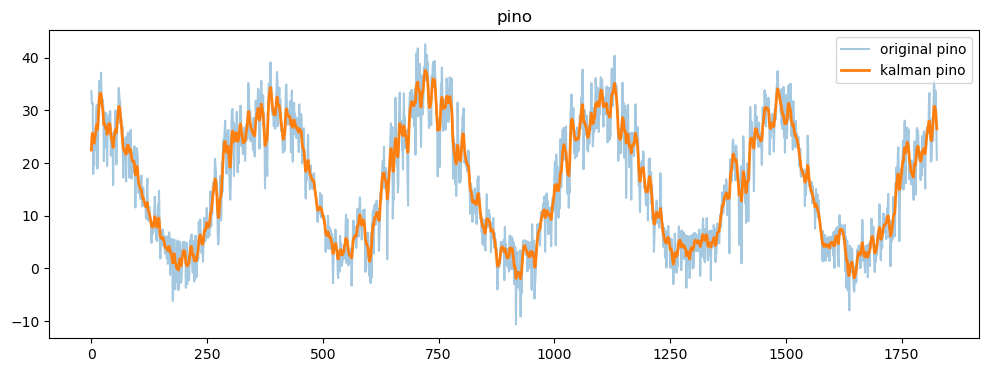

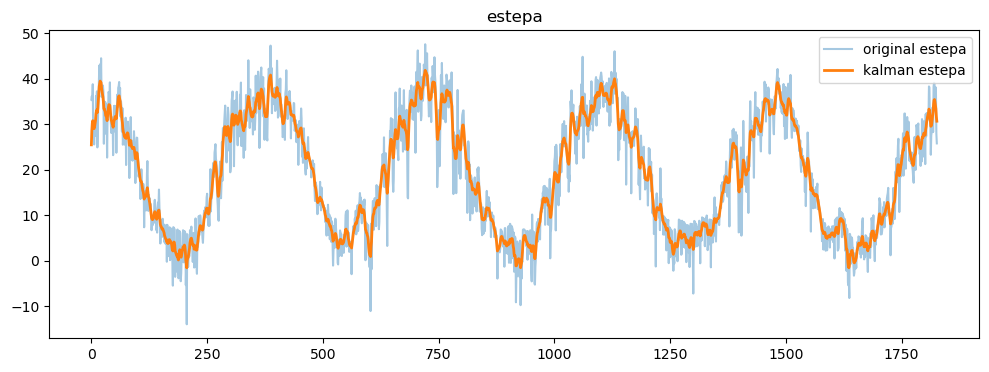

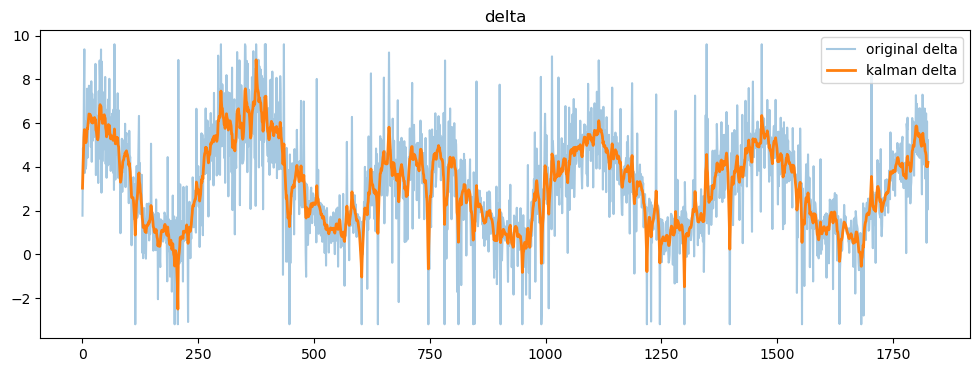

In [33]:
for col in ['pino', 'estepa', 'delta']:
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df_imputed[col], alpha=0.4, label=f'original {col}')
    plt.plot(df.index, df_imputed[f'{col}_kalman'], label=f'kalman {col}', linewidth=2)
    plt.title(col)
    plt.legend()
    plt.show()


Miramos las estadísticas para ver si confirman el resultado preliminar.

In [34]:
df_imputed[['estepa', 'pino', 'delta', 'estepa_kalman',
       'pino_kalman', 'delta_kalman']].describe()

,estepa,pino,delta,estepa_kalman,pino_kalman,delta_kalman
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,19.379332,16.228941,3.193534,19.365373,16.216639,3.148734
std,12.687019,11.059299,2.317443,12.069726,10.485797,1.831678
min,-13.921825,-10.614593,-3.197653,-1.521862,-1.998361,-2.504742
25%,7.990336,6.298978,1.601875,7.614553,5.822463,1.507863
50%,19.335546,15.798626,3.059694,19.744141,16.457572,3.176408
75%,30.596207,25.926555,4.801561,30.540922,25.667428,4.561511
max,47.598174,42.566516,9.601090,41.871942,37.599947,8.890025


Luego de aplicar el filtro, el rango intercuartil y las medidas de tendencia central se modificaron ligeramente. Esto es, se respetó bastante la forma de los datos.

In [35]:
# Exportamos el resultado
df_imputed['estepa'] = df_imputed['estepa_kalman']
df_imputed['pino'] = df_imputed['pino_kalman']
df_imputed['delta'] = df_imputed['delta_kalman']
salida = 'csv/ts_imputado_bilstm_k.csv'
df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)